# PAM-Basisbandübertragung für BPSK

Dieses Notebook dient dazu, das Verständnis für PAM-Übertragung im Allgmeinen zu erhöhen.

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
# import commpy.filters as filters

pi = np.math.pi
%matplotlib inline
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['lines.linewidth'] = 1.5

In [2]:
# globale Definitionen
add_noise = True
SNR = -20 # in dB: SNR auf dem Kanal (input SNR)

N = 400 # Anzahl der Symbole (kann erhoeht werden)
Ts = 4 # Symbolabstand
samples_per_second = 200 # zeitl. Aufloesung
samples_per_symbol = samples_per_second*Ts
delta_t = 1/samples_per_second # wichtig fuer Faltungen

t = np.arange(-10*Ts, 10*Ts, delta_t)

## Definition des Sende- und des Empfangsfilters

Durch die Einführung eines abweichenden Abtastzeitpunktes $t_0 \neq 0$ lässt sich eine Verzögerung einbauen, die so gewählt werden kann, dass Sende- und Empfangsfilter kausale Systeme sind.

In [3]:
# Sende- und Empfangsfilter (Matched Filter)

# Beispielsweise Loesung von Aufgabe 14.6 
# (darum BPSK: Binary Phase Shift Keying!): 
#send_filter = np.sin(pi*t/Ts)*(np.absolute(t) < Ts/2)

# NRZ-Puls: (Rechteck-Puls mit Symboldauer als Breite)
send_filter = (np.absolute(t) < Ts/2)

Eg = np.sum(np.absolute(send_filter)**2)*delta_t
# Matched-Filter:
receive_filter = np.flipud(send_filter)/np.sqrt(Eg)

### Plot der Form des Gesamtpulses p(t)
Mit diesem Plot kann im Zeitbereich beurteilt werden, ob das Nyquistkriterium erfüllt ist.
Dazu muss gelten:

\begin{align}
    p(k T_\mathrm{s}) =  g(t) \ast b(t) \ast f(t)|_{t=kT_\mathrm{s}} \overset{!}{=} C \gamma(k-K)
\end{align}

Erlaubt sind also Skalierungen und Verzögerungen, **jedoch darf jedes Symbol nur einen einzigen Abtastwert im Empfänger beeinflussen**. Zu beachten ist außerdem, dass **immer der Gesamtpuls beurteilt werden muss**!

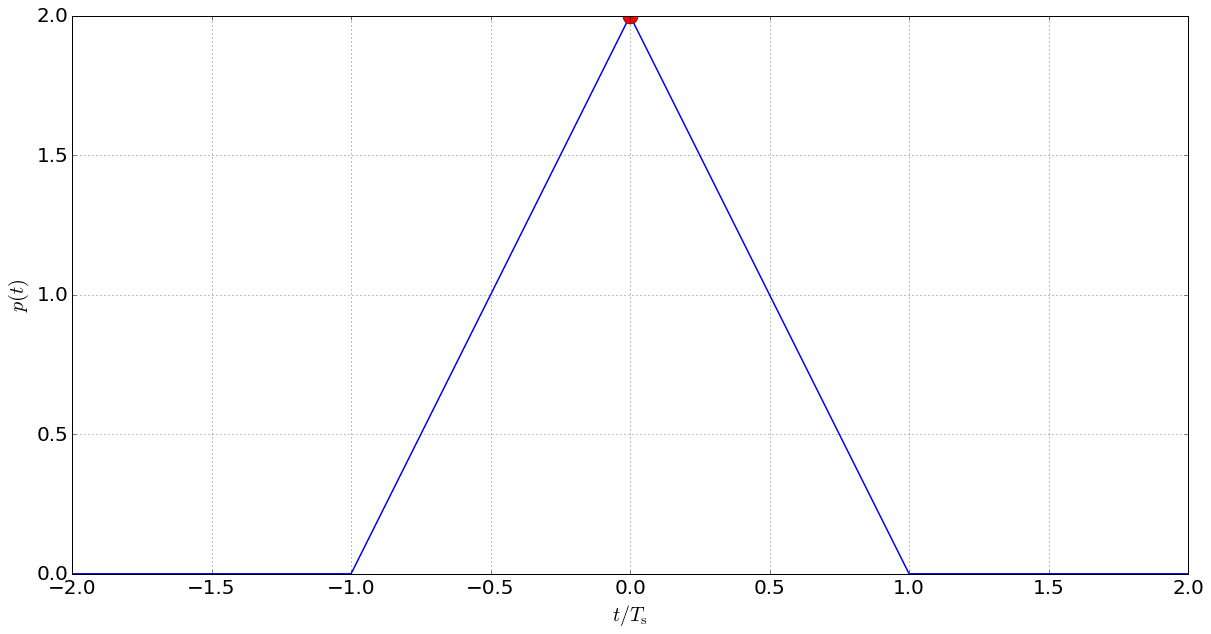

In [4]:
# im Zeitbereich und fuer Kanal mit Dirac-Impulsantwort
complete_pulse = np.convolve(send_filter, receive_filter, 'same')*delta_t
plt.plot(t/Ts, complete_pulse)
plt.plot(t[::samples_per_symbol],
         complete_pulse[::samples_per_symbol], 'ro', markersize=15)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$p(t)$')
plt.xlim((-2, 2))
plt.grid()

Hinweis: Die diskrete Faltung ist eine Summe. Um passende Werte für die kontinuierliche Faltung zu erhalten, muss mit dem Abstand der Zeitpunkte skaliert werden:

\begin{align}
    z(t) = \int_{-\infty}^{\infty} x(\tau) y(t - \tau) \mathrm{d}\tau \approx  \sum_{m=-M}^{M} x(m \Delta t) y( (k- m) \Delta t) \cdot \Delta t = \tilde{z}(k \Delta t)
\end{align}

## Sender

### Symbolfolge und zugehörige Impulsfolge
Die Symbolfolge wird durch Erzeugung gleichverteilter Zufallszahlen generiert. Die zugehörige Impulsfolge ist die Einbettung des diskreten Signals $A(m)$ im Zeitkontinuierlichen:

\begin{align}
    A_\mathrm{cont}(t) = \sum_{m=-\infty}^{\infty} A(m) \delta(t - m T_\mathrm{s})
\end{align}

Dazu muss der Abstand zwischen den Symbolen an die Dauer der Symbole angepasst werden.
Zudem muss jeder (durch die endliche zeitliche Auflösung immer noch diskrete) Impuls skaliert werden, um die gleiche Wirkung wie ein kontinuierlicher Impuls zu haben.

In [5]:
bit_sequence = np.random.rand(N) > 0.5
symbol_sequence = 2*bit_sequence - 1
impulse_sequence = np.zeros(samples_per_symbol*symbol_sequence.shape[0])
impulse_sequence[::samples_per_symbol] = \
    symbol_sequence/delta_t
send_signal = np.convolve(impulse_sequence, send_filter, 'same')*delta_t

### Plot des Sendesignals

\begin{align}
    s(t) = A_\mathrm{cont}(t) \ast g(t) = \sum_{m=-\infty}^{\infty} A(m) g(t - m T_\mathrm{s})
\end{align}

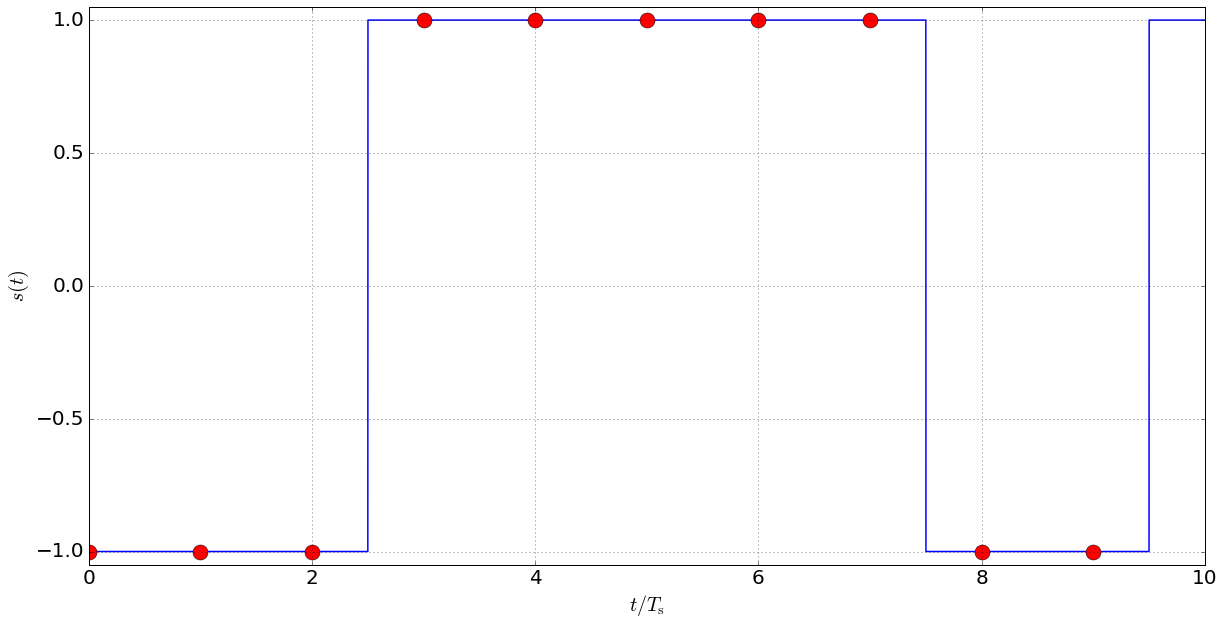

In [6]:
samples_plot_duration = 10*samples_per_symbol
t_plot = delta_t*np.arange(0, samples_plot_duration)
t_symb = t_plot[::samples_per_symbol]
plt.plot(t_plot/Ts, send_signal[:t_plot.shape[0]])
plt.plot(t_symb/Ts, send_signal[:t_plot.shape[0]:samples_per_symbol],
         'ro', markersize=15)
send_lims = (1.05*np.amin(send_signal), 1.05*np.amax(send_signal))
plt.ylim(send_lims)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$s(t)$')
plt.grid()

## Kanal

\begin{align}
    r(t) = s(t) \ast b(t) + n(t) = \sum_{m=-\infty}^{\infty} A(m) h(t - m T_\mathrm{s}) + n(t)
\end{align}

#### Hinweis:
In der Theorie wird mit einem kontinuierlichen weißen Rauschen gerechnet, das deshalb auch unendliche Leistung besitzt. Das ist in der Simulation wegen den endlich großen Abständen in der zeitlichen Darstellung nicht möglich, denn die maximale Bandbreite ist durch die zeitliche Auflösung vorgegeben.  Diskretes weißes Rauschen hat endliche Leistung. Deshalb kann trotzdem ein SNR angegeben werden, das auch Einfluss auf die simulierte Übertragung hat.

In [7]:
# hier nur impulsfoermige Kanalimpulsantwort!
receive_signal = send_signal.copy()
if add_noise:
    Pn = np.var(send_signal)*10**(-SNR/10)
    noise = np.sqrt(Pn)*np.random.standard_normal(send_signal.shape)
    receive_signal += noise

### Plot des Empfangssignals vor dem Empfangsfilter

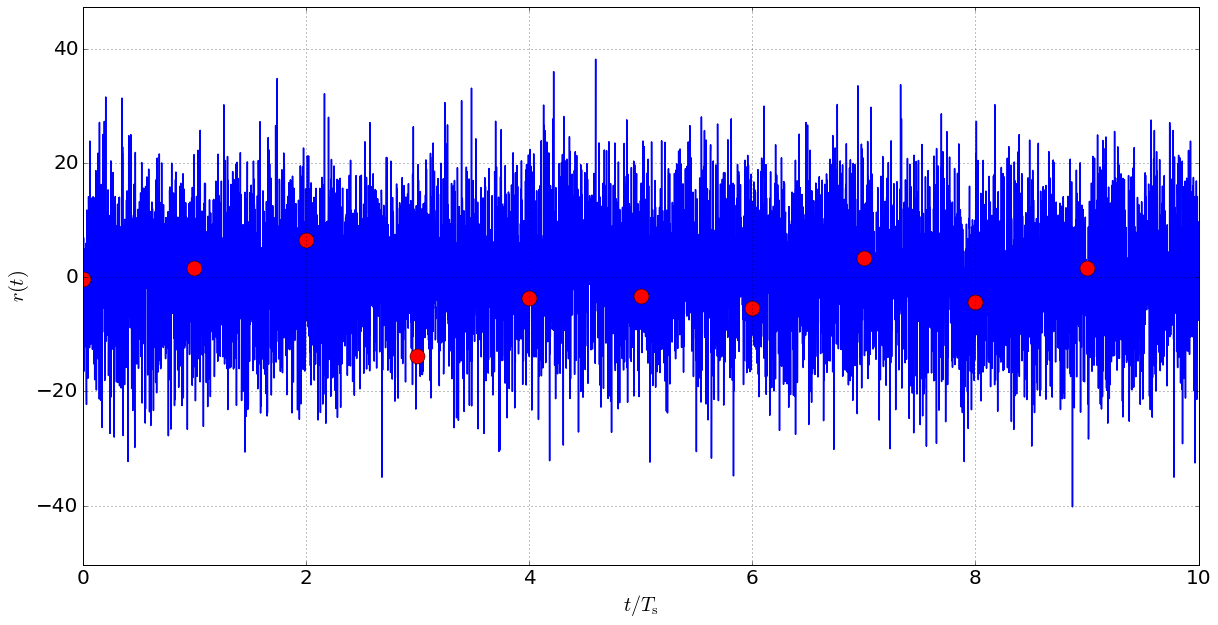

In [8]:
plt.plot(t_plot/Ts, receive_signal[:t_plot.shape[0]])
plt.plot(t_symb/Ts, receive_signal[:t_plot.shape[0]:samples_per_symbol],
         'ro', markersize=15)
rec_lims = (1.05*np.amin(receive_signal), 1.05*np.amax(receive_signal))
plt.ylim(rec_lims)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$r(t)$')
plt.grid()

## Empfänger

### Matched-Filterung

\begin{align}
    q(t) = r(t) \ast f(t) = \sum_{m=-\infty}^{\infty} A(m) p(t - m T_\mathrm{s}) + \tilde{n}(t)
\end{align}

Nach dem Matched-Filter ist die Pulsform jedes zu einem Symbol gehörenden Einzelpulses gleich der Gesamtpulsform.

In [9]:
decision_signal = np.convolve(receive_signal, receive_filter, 'same')*delta_t

### Plot des Entscheidungssignals und der Abtastwerte

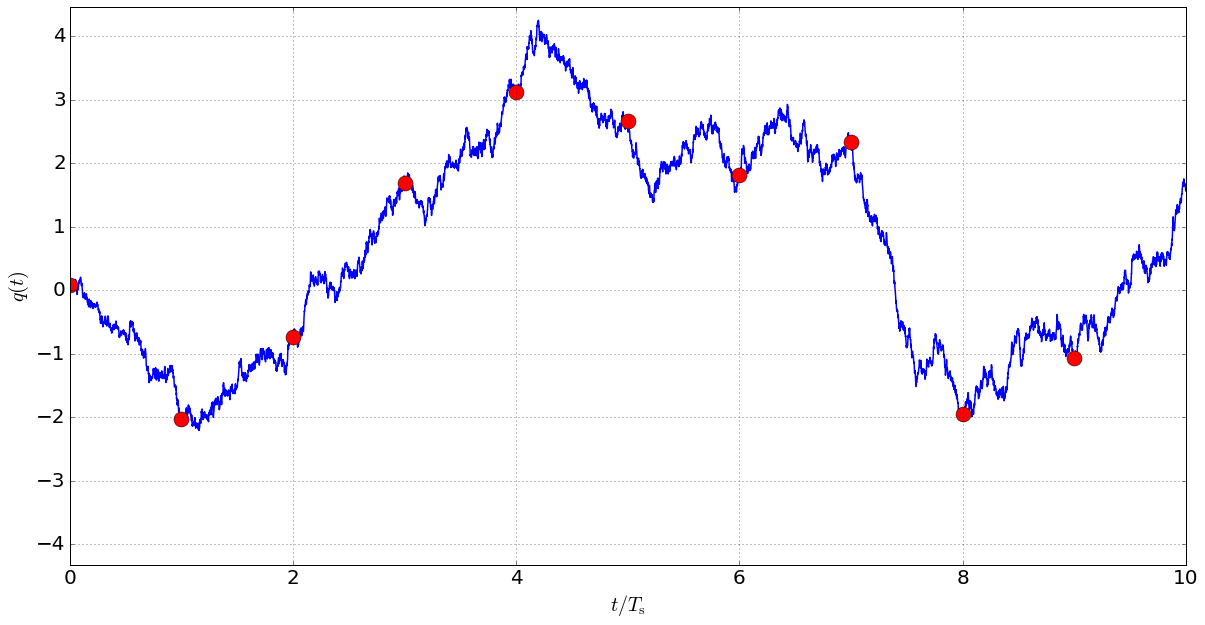

In [10]:
plt.plot(t_plot/Ts, decision_signal[:t_plot.shape[0]])
plt.plot(t_symb/Ts, decision_signal[:t_plot.shape[0]:samples_per_symbol],
         'ro', markersize=15)
dec_lims = (1.05*np.amin(decision_signal), 1.05*np.amax(decision_signal))
plt.ylim(dec_lims)
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.ylabel(r'$q(t)$')
plt.grid()

Hier werden die Auswirkungen des Matched-Filters sichtbar: Obwohl das Störsignal (bei einem SNR von $-20\ \mathrm{dB}$ auf dem Kanal) eine hunderfach höhere Leistung hat als das Nutzsignal, ist das gefilterte Signal dennoch verhältnismäßig eindeutig zu decodieren. Siehe auch das Augendiagramm udn die Erläuterungen am Ende.

### Plot des Augendiagramms

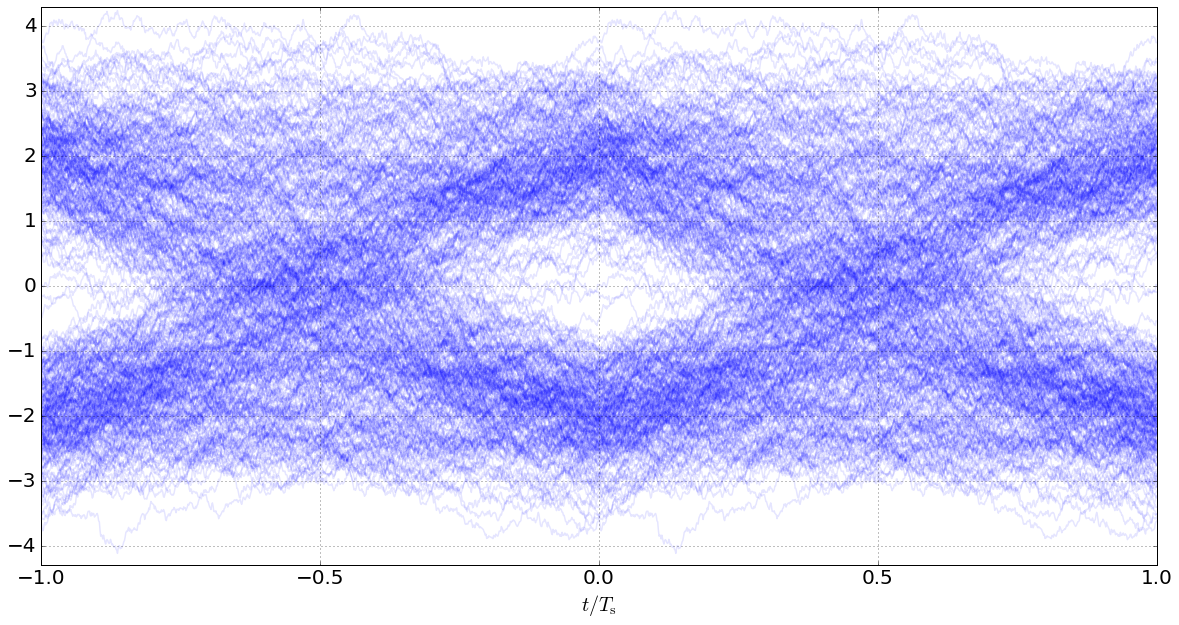

In [11]:
start_symbol_idx = 10
end_symbol_idx = N-10
t_eye = np.linspace(-Ts, Ts, 2*samples_per_symbol)
for n in range(start_symbol_idx, end_symbol_idx):
    decision_signal_current = decision_signal[
        n*samples_per_symbol:(n+2)*samples_per_symbol]
    plt.plot(t_eye/Ts, decision_signal_current, 'b', alpha=0.1)
plt.xlim((-1, 1))
q_max = np.amax(decision_signal)
plt.ylim((-1.01*q_max, 1.01*q_max))
plt.xlabel(r'$t/T_\mathrm{s}$')
plt.grid()

Trotz des schlechten SNRs auf dem Kanal zeigt das Augendiagramm des Entscheidungssignals $q(t)$ vor dem Abtaster ein Auge mit sichtbarer vertikaler Öffnung. Nur sehr selten wird durch das Restrauschen die Entscheidungsgrenze überschritten (in diesem Fall kommt es zu einem Bitfehler).

### SNR vor dem Abtaster zum Abtastzeitpunkt

In [12]:
if add_noise:
    # Nutzsignalanteil des Empfangssignals
    Ps_q = np.var(np.convolve(send_signal, receive_filter, 'same')*delta_t)
    # Stoersignalanteil
    Pn_q = np.var(np.convolve(noise, receive_filter, 'same')*delta_t)
    # SNR
    SNR_q = 10*np.log10(Ps_q/Pn_q)
    print("SNR = {:3.1f} dB".format(SNR_q))

SNR = 7.7 dB


Das Matched-Filter hat einen hohen Anteil daran, das SNR des Entscheidungssignals zu verbessern:
Die Rauschsignalleistung ist nun (bei einem SNR auf dem Kanal von $-20 \mathrm{dB}$) auf etwa ein Fünftel der Nutzsignalleistung gefallen, statt hundertfach höher zu sein.

### Bitfehlerrate

In [13]:
# Decoder
received_bit_sequence = decision_signal[::samples_per_symbol] > 0.5
assert(received_bit_sequence.shape[0] == N)

# geschaetzte Bitfehlerrate
BER = (received_bit_sequence^bit_sequence).sum()/N
print("BER = {:1.5f}".format(BER))

BER = 0.00250


## Zusatz: Matched-Filterung etwas anders erklärt

Für den optimalen Empfänger muss laut Vorlesung gelten:

\begin{align}
    f(t) \overset{!}{=} K \cdot h(t_0 - t) \text{  mit   } h(t) = g(t) \ast b(t)
\end{align}

Anschaulich kann man sich dies so vorstellen:  
Das Sendesignal besteht aus einer Additiven Überlagerung von skalierten, zeitverschobenen Kopien des Sendepulses. Der Kanal verzerrt das Sendesignal mit einer (hier als bekannt angenommenen) Impulsantwort. 
**Damit ist die Signalform h(t) der Pulse im erwarteten Empfangssignal bekannt**.
Unbekannt und störend ist aber das Rauschen, das bei der Übertragung hinzugefügt wird.
Um eine **bekannte Signalform h(t) in einem gegebenen Signal** zu finden, kann man die **Kreuzkorrelation** verwenden, die sich durch eine Faltung (und damit durch eine Filterung) darstellen lässt:

\begin{align}
    \varphi^\mathrm{E}_{hr}(t) &= h(-t) \ast r(t) 
    = \int_{-\infty}^{\infty} h(-\tau) r(t - \tau) \mathrm{d}\tau 
    = \int_{-\infty}^{\infty} r(\tau) h(-(t - \tau)) \mathrm{d}\tau
\end{align}

Wenn $s(t) = A(0) \cdot (g(t)\ast b(t)) = A(0) h(t)$ gesetzt wird, lässt sich $f(t) = h(-t)$ identifizieren. **Die zeitliche Inversion ist also notwenig, damit durch die Faltung eine Korrelation berechnet wird**.  
Der Optimale Abtastzeitpunkt $t_0$ lässt sich durch Umformen bestimmen:

\begin{align}
    \varphi^\mathrm{E}_{hr}(t_0) &= \int_{-\infty}^{\infty} s(\tau) h(-(t - \tau)) \mathrm{d}\tau \\
    &= \int_{-\infty}^{\infty} A(0) h(\tau) h(-(t - \tau)) \mathrm{d}\tau  \\
    &=  A(0) \int_{-\infty}^{\infty} h(\tau) h(-(t - \tau)) \mathrm{d}\tau  \\
    &=  A(0) \int_{-\infty}^{\infty} h(\tau) h(-(t_0) + \tau)) \mathrm{d}\tau \\
    &= A(m) \varphi^\mathrm{E}_{hh}(-(t_0))
\end{align}

Das Vorzeichen vor $t_0$ spielt wegen der geraden AKF keine  Rolle. Das Maximum der AKF ist bei $t_0 = 0$. Dies ist deshalb auch der ideale Abtastzeitpunkt.  
Durch **Einführung einer Verzögerung und gleichzeitiger Verschiebung des Abtastzeitpunktes** um diese Verzögerung kann aber in der Praxis sichergestellt werden, dass **sowohl Sende- als auch Empfangsfilter kausale Systeme** sind. Auch eine Skalierung ist erlaubt, da Nutzsignalanteil und Rauschen in gleicher Weise skaliert werden. So gelangt man zur allgemeineren Definition des Matched-Filters oben.  
Außerdem ist folgende Betrachtungsweise möglich:

\begin{align}
    \varphi^\mathrm{E}_{hr}(0) = \int_{-\infty}^{\infty} r(\tau) h(\tau) \mathrm{d}\tau
\end{align}

Das heißt, **das Matched-Filter berechnet zum Abtastzeitpunkt das Skalarprodukt zwischen Empfangssignal und erwarteter Signalform**.  
Das bisher vernachlässigte Rauschen hat zu jedem Zeitpunkt wenig Ähnlichkeit mit der erwarteten Pulsform und wird deshalb unterdrückt.